In [0]:
# To generate GIFs and install 2.0.0 Beta
!pip install -q imageio
!pip install -q tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 55kB/s 
     |████████████████████████████████| 501kB 49.2MB/s 
     |████████████████████████████████| 3.1MB 55.1MB/s 


In [0]:
#Import libraries for simulation

import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
import PIL.Image
from tensorflow.keras import layers
import time

from io import BytesIO

#Imports for visualization
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display
from IPython.display import HTML

#For 3d projection
from mpl_toolkits.mplot3d import Axes3D


In [0]:
rm -r images3d

In [0]:
#Used to store the images generated by the file writers
mkdir -p images


In [0]:
mkdir -p images3d

In [0]:
class dropsofRain():
  def __init__(self,size):
    #Set the gride size for the images and working parameters
    self.grid_size = size
    self.surface, self.grad = self.init_pond()
    self.image_store = []
    self.image = None
    
    self.X = np.arange(self.grid_size)
    self.Y = np.arange(self.grid_size)
    self.X,self.Y = np.meshgrid(self.X,self.Y)

  
  def init_pond(self):
    # Initialize the playing field to zero
    u_init = np.zeros([self.grid_size, self.grid_size], dtype=np.float32)
    ut_init = np.zeros([self.grid_size, self.grid_size], dtype=np.float32)

    # Some rain drops hit a pond at random points to start
    for n in range(40):
      a,b = np.random.randint(0, self.grid_size, 2)
      u_init[a,b] = np.random.uniform()
    return(tf.Variable(u_init),tf.Variable(ut_init))
  
  @tf.function
  def pde_step(self,eps,damping):
    #Update function the discretized grid
    U_ = self.surface + eps * self.grad
    Ut_ = self.grad + eps * (self.laplace(self.surface) - damping * self.grad)
    self.surface.assign(U_)
    self.grad.assign(Ut_)
  
  def run_sim(self,n_runs,eps = 0.1,damp = 0.1):
    #Run the simulation N times thena ppend vlaues of grid to an image store
    for i in range(n_runs):
      if i %5 == 0:
        a,b = np.random.randint(0, self.grid_size, 2)
        val = np.random.uniform()
        self.surface[a,b].assign(val)
      self.pde_step(eps,damp)
      #plt.plot(pond.numpy())
      self.DisplayArray(i)
 
    
  def make_kernel(self,a):
    """Transform a 2D array into a convolution kernel"""
    a = np.asarray(a)
    a = a.reshape(list(a.shape) + [1,1])
    return tf.constant(a, dtype=1)

  def simple_conv(self,x, k):
    """A simplified 2D convolution operation"""
    x = tf.expand_dims(tf.expand_dims(x, 0), -1)
    y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
    return y[0, :, :, 0]
  
  def laplace(self,x):
    #The convolutional kernel values can be found for the laplacian on Wikipedia
    laplace_k = self.make_kernel([[0.5, 1.0, 0.5],
                             [1.0, -6., 1.0],
                             [0.5, 1.0, 0.5]])
    return self.simple_conv(x, laplace_k)
    
    

  def DisplayArray(self,i,fmt='png', rng=[0,1]):
  #Using matplotlib to clip values in range 0,255 then save in image store
    array = (self.surface - rng[0])/float(rng[1] - rng[0])*255
    array = np.uint8(np.clip(array, 0, 255))
    self.image_store.append(array)


  def make_files(self):
    #Transform image store into files 
    for i, img in enumerate(self.image_store):
      f = 'images/image_{:04d}.png'.format(i)
      plt.imsave(f, img, cmap = 'plasma',vmin=0,vmax=1)
  
  def make_3d_files(self):
    #Used to make the 3d surface plots for an animation of the same pond
    for i, img in enumerate(self.image_store):
      f = 'images3d/image_{:04d}.png'.format(i)
      
      fig = plt.figure(figsize=(8,8))
      ax = fig.gca(projection='3d')

      ax.plot_surface(self.X,self.Y,Z=img,cmap='plasma',linewidth=2, antialiased=False,shade=True)
      plt.axis('off')
      ax.view_init(elev=20, azim=0.01*i)
      plt.savefig(f,dpi=300)
      
      plt.close()
      
  def make_3d_gif(self):
    #Same as make_gif but make the 3d files
    self.make_gif('images3d/image_*.png',gif_name='plasma3d.gif')
  
  def make_gif(self,path='images/image_*.png',gif_name='plasma.gif'):
    #Convert all the files into a gif
    anim_file = gif_name
    with imageio.get_writer(anim_file, mode='I') as writer:
      filenames = glob.glob(path)
      filenames = sorted(filenames)
      last = -1
      for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
          last = frame
        else:
          continue
        image = imageio.imread(filename)
        writer.append_data(image)
      image = imageio.imread(filename)
      writer.append_data(image)

In [0]:
#Make the Pond and run 2000 iterations
my_pond = dropsofRain(500)
my_pond.run_sim(2000,eps=0.03,damp=0.04)

In [0]:
#Make 3d files for animation
my_pond.make_files()
my_pond.make_gif()

In [0]:
#Make the 3d files for animation
my_pond.make_3d_files()
my_pond.make_3d_gif()

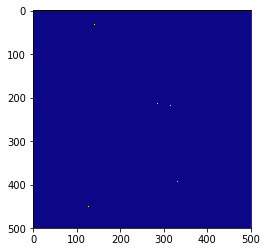

In [0]:
#This is an alternate method for making the animation, not a real perfomance gain
sequence = my_pond.image_store
fig = plt.figure()

im = plt.imshow(sequence[0],cmap = 'plasma',vmin=0,vmax=1)

def update_fig(i):
    im.set_array(sequence[i])
    return [im]
ani = animation.FuncAnimation(fig,update_fig,frames = range(5000),
                              blit=True,interval=15)


In [0]:
ani.save('plasma2.gif',writer='pillow',dpi=300)

In [0]:
HTML(ani.to_html5_video())